Time of flight: 0.80 seconds
Velocity of the fuel: 6.70 m/s
Omega of the shooter wheel: 87.93 rad/s or 13.99 turns/s
Target yaw: 30.75°
Current yaw: 0.00°
Delta yaw: 30.75°
Max horizontal distance (range): 2.01 meters
Ending height: 1.83 meters or 6.00 feet or 72.00 in
Max height: 1.97 meters or 6.46 feet or 77.53 in


Text(0.5, 1.0, 'Field Map')

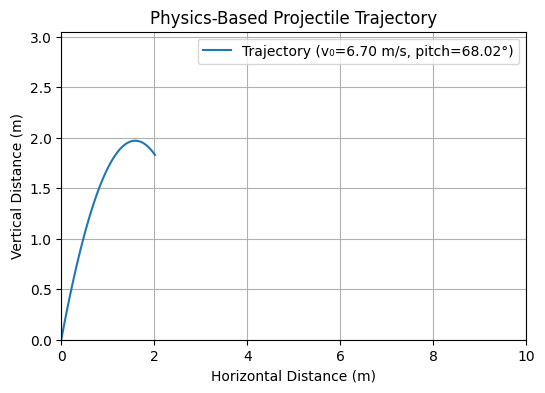

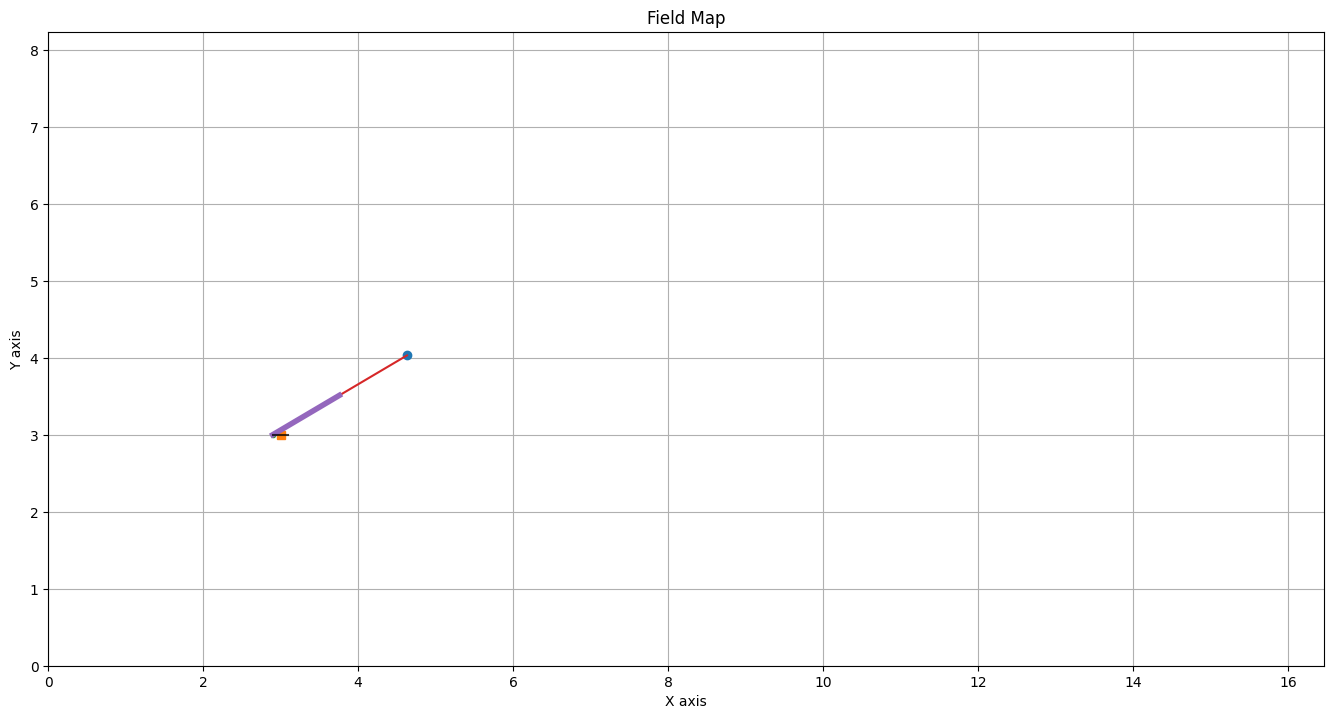

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math

class Translation3d:
    def __init__(self, x: float, y: float, z: float):
        self.x = x
        self.y = y
        self.z = z

    def __str__(self):
        return f"X: {self.x}, Y: {self.y}, Z: {self.z}"

class Rotation3d:
    def __init__(self, roll: float, pitch: float, yaw: float):
        self.roll = math.radians(roll)
        self.pitch = math.radians(pitch)
        self.yaw = math.radians(yaw)

    def __str__(self):
        return f"Roll: {math.degrees(self.roll)}, Pitch: {math.degrees(self.pitch)}, Yaw: {math.degrees(self.yaw)}"


class Pose3d:
    def __init__(self, translation: Translation3d, rotation: Rotation3d):
        self.translation = translation
        self.x = self.translation.x
        self.y = self.translation.y
        self.z = self.translation.z
        self.rotation = rotation
        self.roll = self.rotation.roll
        self.pitch = self.rotation.pitch
        self.yaw = self.rotation.yaw

    def __str__(self):
        return str(self.translation) + "\n" + str(self.rotation)

def hypotenuse(x, y):
    return math.sqrt(x**2 + y**2)
    
def hypotenuse3(x, y, z):
    return math.sqrt(x**2 + y**2 + z**2)

def projectile_trajectory(v0, angle, time_points, g=-9.8):
    # Calculate initial velocity components
    vx0 = v0 * math.cos(angle)
    vy0 = v0 * math.sin(angle)

    # Calculate positions at each time point
    # x = vx0 * t
    x_positions = vx0 * time_points
    # y = vy0 * t - 0.5 * g * t^2
    y_positions = (vy0 * time_points) + (0.5 * g * time_points**2)

    return x_positions, y_positions

def ft_to_m(feet):
    return feet / 3.28084

def m_to_ft(meters):
    return meters * 3.28084

def in_to_m(inches):
    return inches / 39.3701




blue_hub_pose = Translation3d(4.63, 4.03, 1.8288)
red_hub_pose = Translation3d(11.9, blue_hub_pose.y, blue_hub_pose.z)


hub_pose = blue_hub_pose
robot_pose = Pose3d(Translation3d(3, 3, 0), Rotation3d(0, 0, 0)) # X, Y, Z, Roll, Pitch, Yaw
robot_velocity = Pose3d(Translation3d(0, 0, 0), Rotation3d(0, 0, 0)) # V_x, V_y, V_z, Omega_roll, Omega_pitch, Omega_yaw

turret_offset = Translation3d(-in_to_m(4), 0, in_to_m(6))
turret_theta_offset = math.atan2(turret_offset.y, turret_offset.x) 
turret_radius = hypotenuse(turret_offset.x, turret_offset.y)

turret_x = robot_pose.x + math.cos(robot_pose.yaw + turret_theta_offset) * turret_radius
turret_y = robot_pose.y + math.sin(robot_pose.yaw + turret_theta_offset) * turret_radius
turret_v_x = robot_velocity.x - math.sin(robot_pose.yaw - turret_theta_offset) * turret_radius * robot_velocity.yaw
turret_v_y = robot_velocity.y + math.cos(robot_pose.yaw - turret_theta_offset) * turret_radius * robot_velocity.yaw

g = -9.8
delta_z = hub_pose.z - robot_pose.z

pitch = math.radians(68.017) - robot_pose.pitch

delta_x = hub_pose.x - turret_x
delta_y = hub_pose.y - turret_y

delta_r = hypotenuse(delta_x, delta_y)

time_of_flight = math.sqrt((2 * (delta_r * math.tan(pitch) - delta_z)) / -g)

v_z = (delta_z - 0.5 * g * time_of_flight**2) / time_of_flight
v_r = v_z / math.tan(pitch)
v_x = math.cos(math.atan2(delta_y, delta_x)) * v_r - turret_v_x
v_y = math.sin(math.atan2(delta_y, delta_x)) * v_r - turret_v_y
v_fuel = hypotenuse3(v_x, v_y, v_z)


shooter_wheel_radius = in_to_m(3)
shooter_omega = v_fuel / shooter_wheel_radius

yaw = math.atan2(v_y, v_x)

t = np.linspace(0, time_of_flight, num=100)
# Calculate the trajectory
x, y = projectile_trajectory(v_fuel, pitch, t, g)

# Filter out points where y is negative (below the ground)
# This handles cases where the time array extends slightly past impact due to linspace
positive_y_indices = y >= 0
x = x[positive_y_indices]
y = y[positive_y_indices]

# Print some results
print(f"Time of flight: {time_of_flight:.2f} seconds")
print(f"Velocity of the fuel: {v_fuel:.2f} m/s")
print(f"Omega of the shooter wheel: {shooter_omega:.2f} rad/s or {(shooter_omega / (2 * math.pi)):.2f} turns/s")
print(f"Target yaw: {math.degrees(yaw):.2f}°")
print(f"Current yaw: {math.degrees(robot_pose.yaw):.2f}°")
print(f"Delta yaw: {math.degrees(yaw - robot_pose.yaw):.2f}°")
print(f"Max horizontal distance (range): {x[-1]:.2f} meters")
print(f"Ending height: {y[-1]:.2f} meters or {m_to_ft(y[-1]):.2f} feet or {(m_to_ft(y[-1])*12):.2f} in")
print(f"Max height: {max(y):.2f} meters or {m_to_ft(max(y)):.2f} feet or {(m_to_ft(max(y))*12):.2f} in")

# Plotting the trajectory
fig1, ax1 = plt.subplots(figsize=(6, 4))

ax1.plot(
    x, y,
    label=f'Trajectory (v₀={v_fuel:.2f} m/s, pitch={math.degrees(pitch):.2f}°)'
)

ax1.set_title('Physics-Based Projectile Trajectory')
ax1.set_xlim(0, max(10, x[-1]))
ax1.set_ylim(0, ft_to_m(10))  # Ensure y-axis starts at 0
ax1.set_xlabel('Horizontal Distance (m)')
ax1.set_ylabel('Vertical Distance (m)')
ax1.grid(True)
ax1.legend()

fig2, ax2 = plt.subplots(figsize=(16.46, 8.23))

# Plot a point on that axes
ax2.plot(hub_pose.x, hub_pose.y, marker='o')
ax2.plot(robot_pose.x, robot_pose.y, marker='s')
ax2.plot(turret_x, turret_y, marker='.')

x = np.linspace(turret_x, hub_pose.x, 100)
y = np.linspace(turret_y, hub_pose.y, 100)
ax2.plot(x, y)

x = np.linspace(turret_x, turret_x + 1 * math.cos(yaw), 100)
y = math.tan(yaw) * (x - turret_x) + turret_y
ax2.plot(x, y, linewidth=4)

x = np.linspace(turret_x, turret_x + turret_v_x, 100);
y = 0 * x + turret_y
ax2.plot(x, y)

y = np.linspace(turret_y, turret_y + turret_v_y, 100);
ax2.plot(x, y)
x = 0 * y + turret_x
ax2.plot(x, y)

x = np.linspace(turret_x, turret_x + 0.2 * math.cos(robot_pose.yaw), 100)
y = np.linspace(turret_y, turret_y + 0.2 * math.sin(robot_pose.yaw), 100)
ax2.plot(x, y, color='k', alpha=0.75)

# Optional formatting
ax2.set_xlabel("X axis")
ax2.set_xlim(0, 16.46)
ax2.set_ylabel("Y axis")
ax2.set_ylim(0, 8.23)
ax2.grid(True)
ax2.set_title("Field Map")
